# Personal Finance Advisor – NLP & LLM Pipeline

This notebook implements:
- NLP-based transaction categorization
- Multi-item transaction handling
- Multiple transaction batch processing
- Explainable amount allocation
- Analytical, numerical, and textual outputs
- Local LLM (Ollama) for explanations and advice

# Imports & Global Configuration

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from typing import List, Dict

# Data Validation (Edge Cases: Empty / Missing Columns)

## Data Validation
Ensures uploaded data is usable before processing.

In [2]:
REQUIRED_COLUMNS = {"description", "amount"}

def validate_dataframe(df: pd.DataFrame):
    if df.empty:
        raise ValueError("Input data is empty.")

    missing = REQUIRED_COLUMNS - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    return True

# Amount Cleaning (₹ symbols, commas, negatives)

## Amount Cleaning
Handles non-numeric values, currency symbols, refunds, and invalid entries.

In [3]:
def clean_amount(amount):
    if pd.isna(amount):
        return None

    if isinstance(amount, str):
        amount = re.sub(r"[₹,]", "", amount)

    try:
        amount = float(amount)
        if amount <= 0:
            return None
        return amount
    except:
        return None

# Cleaning & Validation

## Description Cleaning
Filters very short, empty, or invalid transaction descriptions.

In [4]:
def clean_text(text):
    if not isinstance(text, str):
        return None

    text = text.strip().lower()
    if len(text) < 3:
        return None

    return text

# Multi-Item Transaction Splitter

## Multi-item Transaction Handling
Splits combined purchases into logical sub-transactions.

In [5]:
def split_transaction(description: str) -> List[str]:
    parts = re.split(r",| and |;", description)
    return [p.strip() for p in parts if len(p.strip()) > 3]

# Category Weights for Explainable Allocation

## Category Weights
Used to distribute amount fairly when multiple items exist.

In [6]:
CATEGORY_WEIGHTS = {
    "food": 1.2,
    "utilities": 1.5,
    "subscriptions": 1.0,
    "travel": 1.3,
    "shopping": 1.1,
    "healthcare": 1.4,
    "others": 1.0
}

# Amount Allocation Engine

## Amount Allocation
Distributes total amount across sub-transactions using weighted heuristics.

In [7]:
def allocate_amount(items, categories, total_amount):
    weights = [CATEGORY_WEIGHTS.get(cat.lower(), 1.0) for cat in categories]
    weight_sum = sum(weights)

    allocations = []
    for item, cat, w in zip(items, categories, weights):
        amt = round((w / weight_sum) * total_amount, 2)
        allocations.append({
            "item": item,
            "category": cat,
            "allocated_amount": amt
        })

    return allocations

# CORE PIPELINE (MULTIPLE TRANSACTIONS AT ONCE)

## Core Processing Pipeline
Processes multiple transactions and handles all edge cases.

In [8]:
def process_transactions(df: pd.DataFrame) -> Dict:
    validate_dataframe(df)

    processed = []
    skipped_rows = []

    for idx, row in df.iterrows():
        desc = clean_text(row["description"])
        amt = clean_amount(row["amount"])

        if desc is None or amt is None:
            skipped_rows.append(idx)
            continue

        items = split_transaction(desc)

        categories = predict_transaction_category(items)

        allocation = allocate_amount(items, categories, amt)
        processed.extend(allocation)

    return 
    {
        "processed_df": pd.DataFrame(processed),
        "skipped_rows": skipped_rows
    }

# Analytical Aggregation

## Analytical Aggregation
Generates category-wise expenditure summaries.

In [9]:
def analytics_summary(df):
    return 
    (
        df.groupby("category")["allocated_amount"]
        .sum()
        .reset_index()
        .sort_values(by="allocated_amount", ascending=False)
    )

# Visual Analytics

## Visual Analytics
Bar and Pie charts for spending distribution.

In [10]:
def plot_bar(summary_df):
    plt.figure(figsize=(6,4))
    plt.bar(summary_df["category"], summary_df["allocated_amount"])
    plt.title("Category-wise Spending")
    plt.ylabel("Amount (₹)")
    plt.xticks(rotation=45)
    plt.show()


def plot_pie(summary_df):
    plt.figure(figsize=(6,6))
    plt.pie(
        summary_df["allocated_amount"],
        labels=summary_df["category"],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title("Spending Distribution")
    plt.show()

# LLM Explanation (LOCAL OLLAMA)

## LLM Explanation Layer
Uses a local LLM to explain spending behavior in natural language.

In [11]:
import ollama

def llm_summary(summary_df, total_amount):
    table = summary_df.to_string(index=False)

    prompt = f"""
The user spent a total of ₹{total_amount}.
Below is the categorized spending breakdown:

{table}

Provide a short financial insight.
"""

    response = ollama.chat(
        model="llama3.1:8b",
        messages=[
            {"role": "system", "content": "You are a financial analyst."},
            {"role": "user", "content": prompt}
        ]
    )

    return response["message"]["content"]

## NLP-Based Transaction Categorization (Logistic Regression)

This section implements:
- Text preprocessing
- Feature extraction using TF-IDF
- Transaction categorization using Logistic Regression
- A reusable prediction function for downstream pipelines

# Imports

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare NLP Dataset

## Dataset Preparation for NLP
Cleans descriptions and prepares labels for training.

In [13]:
df_nlp = pd.read_csv("transactions_clean.csv")

df_nlp = df_nlp.dropna(subset=["description", "category"])
df_nlp["description"] = df_nlp["description"].astype(str).str.lower()

X_text = df_nlp["description"]
y_labels = df_nlp["category"]

# Train / Test Split

## Train-Test Split
Splits data to evaluate generalization.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_text,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

# TF-IDF Vectorization

## TF-IDF Feature Extraction
Converts transaction descriptions into numerical vectors.

In [15]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression Model Training

## Logistic Regression Classifier
Performs multi-class transaction categorization.

In [16]:
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

clf.fit(X_train_tfidf, y_train)

/Users/ayanbiswas/Desktop/CN Projects/Personal Finance Advisor Team/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

# Prediction

In [17]:
def predict_transaction_category(text_list):
    """
    Predict categories for a list of transaction descriptions
    using TF-IDF + Logistic Regression.
    """
    # Clean input text
    cleaned = []
    for t in text_list:
        ct = clean_text(t)
        if ct is not None:
            cleaned.append(ct)

    if len(cleaned) == 0:
        return []

    # Vectorize
    X_vec = tfidf.transform(cleaned)

    # Predict
    preds = clf.predict(X_vec)

    return preds.tolist()

# Model Evaluation

## Model Evaluation Metrics

This section evaluates the Logistic Regression model using:
- Accuracy
- Precision
- Recall
- F1-score

Accuracy represents the overall correctness of predictions.

In [18]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.97515

Classification Report:
               precision    recall  f1-score   support

        bills       1.00      0.75      0.86      2008
    education       1.00      1.00      1.00       824
entertainment       1.00      1.00      1.00      1596
         food       1.00      1.00      1.00      4030
    groceries       1.00      1.00      1.00      3628
       health       1.00      1.00      1.00      1187
         rent       1.00      1.00      1.00      1202
     shopping       1.00      1.00      1.00      1958
       travel       1.00      1.00      1.00      2375
    utilities       0.71      1.00      0.83      1192

     accuracy                           0.98     20000
    macro avg       0.97      0.98      0.97     20000
 weighted avg       0.98      0.98      0.98     20000



# Quick NLP Test

In [19]:
test_samples = [
    "paid electricity bill",
    "zomato food order",
    "netflix subscription",
    "uber ride"
]

predict_transaction_category(test_samples)

['bills', 'shopping', 'entertainment', 'food']

# INTEGRATED PIPELINE OVERVIEW

# Integrated Personal Finance Advisor Pipeline

This section connects all modules:
- NLP categorization (TF-IDF + Logistic Regression)
- Multi-item transaction handling
- Batch transaction processing
- Amount allocation
- Analytical summaries
- LLM-based explanations

A single input flows through all components to produce:
- Category predictions
- Numerical breakdown
- Visual analytics
- Textual financial insights

# IMPORTS

In [20]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from typing import List, Dict
import ollama

# NLP Model

## NLP Model Assumption

The following objects are assumed to be already trained and available:
- tfidf (TfidfVectorizer)
- clf (LogisticRegression)
- clean_text()
- predict_transaction_category()

This cell does not retrain the model.

## Multi-item Transaction Splitter

In [21]:
def split_transaction(description: str) -> List[str]:
    parts = re.split(r",| and |;", description)
    return [p.strip() for p in parts if len(p.strip()) > 3]

# AMOUNT CLEANING

In [22]:
def clean_amount(amount):
    if pd.isna(amount):
        return None

    if isinstance(amount, str):
        amount = re.sub(r"[₹,]", "", amount)

    try:
        amount = float(amount)
        if amount <= 0:
            return None
        return amount
    except:
        return None

# CATEGORY WEIGHTS

In [23]:
CATEGORY_WEIGHTS = {
    "Food": 1.2,
    "Utilities": 1.5,
    "Subscriptions": 1.0,
    "Travel": 1.3,
    "Shopping": 1.1,
    "Healthcare": 1.4,
    "Others": 1.0
}

# AMOUNT ALLOCATION MODULE

In [24]:
def allocate_amount(items, categories, total_amount):
    weights = [CATEGORY_WEIGHTS.get(cat, 1.0) for cat in categories]
    weight_sum = sum(weights)

    allocation = []
    for item, cat, w in zip(items, categories, weights):
        amt = round((w / weight_sum) * total_amount, 2)
        allocation.append({
            "item": item,
            "category": cat,
            "allocated_amount": amt
        })

    return allocation

# CORE INTEGRATION PIPELINE

## Core End-to-End Processing Pipeline
Handles multiple transactions and edge cases.

In [30]:
def run_finance_pipeline(df: pd.DataFrame) -> dict:
    if df is None or df.empty:
        raise ValueError("Input DataFrame is empty or None")

    all_results = []
    skipped_rows = []

    for idx, row in df.iterrows():
        desc = clean_text(row["description"])
        amt = clean_amount(row["amount"])

        if desc is None or amt is None:
            skipped_rows.append(idx)
            continue

        items = split_transaction(desc)

        if not items:
            skipped_rows.append(idx)
            continue

        categories = predict_transaction_category(items)

        if len(categories) != len(items):
            skipped_rows.append(idx)
            continue

        allocation = allocate_amount(items, categories, amt)
        all_results.extend(allocation)

    if not all_results:
        return {
            "processed_df": pd.DataFrame(columns=["item", "category", "allocated_amount"]),
            "summary_df": pd.DataFrame(columns=["category", "allocated_amount"]),
            "skipped_rows": skipped_rows
        }

    processed_df = pd.DataFrame(all_results)

    summary_df = (
        processed_df
        .groupby("category", as_index=False)["allocated_amount"]
        .sum()
        .sort_values(by="allocated_amount", ascending=False)
    )

    return {
        "processed_df": processed_df,
        "summary_df": summary_df,
        "skipped_rows": skipped_rows
    }

# ANALYTICAL VISUALIZATIONS

In [31]:
def plot_bar(summary_df):
    plt.figure(figsize=(6,4))
    plt.bar(summary_df["category"], summary_df["allocated_amount"])
    plt.title("Category-wise Spending")
    plt.ylabel("Amount (₹)")
    plt.xticks(rotation=45)
    plt.show()


def plot_pie(summary_df):
    plt.figure(figsize=(6,6))
    plt.pie(
        summary_df["allocated_amount"],
        labels=summary_df["category"],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title("Spending Distribution")
    plt.show()

## LLM Explanation Module (Local LLM)

In [32]:
def llm_financial_summary(summary_df, total_amount):
    table = summary_df.to_string(index=False)

    prompt = f"""
A user spent a total of ₹{total_amount}.

Category-wise breakdown:
{table}

Provide a concise financial insight and suggestion.
"""

    response = ollama.chat(
        model="llama3.1:8b",
        messages=[
            {"role": "system", "content": "You are a financial analyst."},
            {"role": "user", "content": prompt}
        ]
    )

    return response["message"]["content"]

# SAMPLE INPUT (MULTIPLE TRANSACTIONS)

In [33]:
sample_input = pd.DataFrame({
    "description": [
        "Bought groceries from Reliance, Netflix subscription",
        "Paid electricity bill",
        "Uber ride and coffee",
        "Amazon shopping and mobile recharge"
    ],
    "amount": [1800, 1200, 350, 1500]
})

## Running Full Pipeline

,item,category,allocated_amount
0,bought groceries from reliance,groceries,900.0
1,netflix subscription,entertainment,900.0
2,paid electricity bill,bills,1200.0
3,uber ride,food,175.0
4,coffee,food,175.0
5,amazon shopping,shopping,750.0
6,mobile recharge,bills,750.0


,category,allocated_amount
0,bills,1950.0
1,entertainment,900.0
3,groceries,900.0
4,shopping,750.0
2,food,350.0


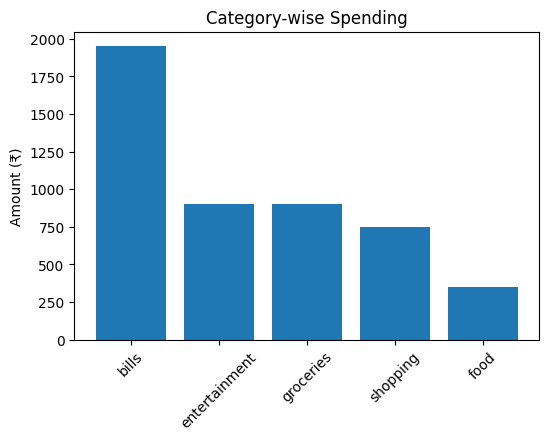

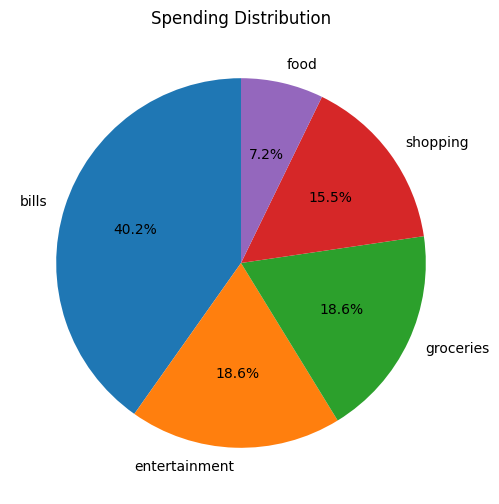

**Financial Insight:**
The user's spending breakdown reveals a balanced allocation of funds across essential categories such as bills, groceries, and food, which account for approximately 72% of the total expenditure. However, there is scope for improvement in managing discretionary expenses.

**Suggestion:**

1. **Re-evaluate entertainment budget**: ₹900 allocated to entertainment might be too high considering the overall expenses. Consider reducing this by 10-20% (₹90-180) and allocate it towards essential categories or savings.
2. **Optimize shopping habits**: The ₹750 allocated to shopping could potentially be reduced by allocating funds from discretionary categories or finding alternative, more affordable options.
3. **Monitor food expenses**: While ₹350 for food is reasonable, consider meal planning and preparation at home to minimize dining out costs.

**Recommendation:** Adjust the budget to allocate excess funds towards savings, retirement planning, or other essential categori

In [34]:
output = run_finance_pipeline(sample_input)

processed_df = output["processed_df"]
summary_df = output["summary_df"]

display(processed_df)
display(summary_df)

plot_bar(summary_df)
plot_pie(summary_df)

total_spent = processed_df["allocated_amount"].sum()
print(llm_financial_summary(summary_df, total_spent))